# ボクセルベース地形生成（改善版v3）

## 改善ポイント（v3）
1. **広範囲補間**: 高度差に応じて坂の範囲を広く取る（HTMLの実装を参考）
2. **通路の高度差をさらに縮小**: 2-4mに制限
3. **境界からの距離ベース補間**: 通路境界からの距離に応じた滑らかな補間
4. **30-40度の緩やかな坂を増やす**: 広範囲補間により実現

In [6]:
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from collections import deque
import random

# 日本語フォント設定（Windows環境）
plt.rcParams['font.family'] = ['Yu Gothic', 'MS Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("ライブラリのインポート完了")

ライブラリのインポート完了


## 1. ボロノイ分割と大領域グループ化

In [7]:
class VoronoiTerrain:    def __init__(self, width=100, height=100, num_sites=200, num_groups=15):        self.width = width        self.height = height        self.num_sites = num_sites        self.num_groups = num_groups                self.points = self._generate_relaxed_points()        self.vor = Voronoi(self.points)        self.cell_map = self._build_cell_map()        self.group_map = self._create_groups()        self.group_edges = self._build_group_edges()        self._generate_maze()        self.group_heights = self._propagate_heights()                # 境界ピクセルと距離フィールドを計算        self._compute_boundary_pixels_and_distance_field()                # 境界の中央点を計算        self._compute_boundary_centroids()                # 角度ベースの高度マップ        self.height_map = self._create_angle_based_height_map()        def _generate_relaxed_points(self, iterations=3):        """Lloyd緩和でより均等な点配置"""        points = np.random.rand(self.num_sites, 2)        points[:, 0] *= self.width        points[:, 1] *= self.height                for _ in range(iterations):            vor = Voronoi(points)            centroids = []                        for i, region_idx in enumerate(vor.point_region):                region = vor.regions[region_idx]                if -1 in region or len(region) == 0:                    centroids.append(points[i])                    continue                                vertices = vor.vertices[region]                centroid = vertices.mean(axis=0)                centroid[0] = np.clip(centroid[0], 0, self.width)                centroid[1] = np.clip(centroid[1], 0, self.height)                centroids.append(centroid)                        points = np.array(centroids)                return points        def _build_cell_map(self):        """各ピクセルに最も近いセルIDを割り当て"""        cell_map = np.zeros((self.height, self.width), dtype=int)                for y in range(self.height):            for x in range(self.width):                distances = np.sqrt((self.points[:, 0] - x)**2 + (self.points[:, 1] - y)**2)                cell_map[y, x] = np.argmin(distances)                return cell_map        def _create_groups(self):        """セルをグループ化（母点数で小:中:大 = 1:3:9、出現確率均等）"""        num_each = self.num_groups // 3        remainder = self.num_groups % 3                size_types = []        size_types.extend(['small'] * (num_each + (1 if remainder > 0 else 0)))        size_types.extend(['medium'] * (num_each + (1 if remainder > 1 else 0)))        size_types.extend(['large'] * num_each)                random.shuffle(size_types)                cells_per_group = self.num_sites / self.num_groups        target_sizes = []        for size_type in size_types:            if size_type == 'small':                target_sizes.append(int(cells_per_group * 1.0))            elif size_type == 'medium':                target_sizes.append(int(cells_per_group * 3.0))            else:                target_sizes.append(int(cells_per_group * 9.0))                seeds = [random.randint(0, self.num_sites - 1)]                while len(seeds) < self.num_groups:            max_min_dist = -1            best_candidate = -1                        for i in range(self.num_sites):                if i in seeds:                    continue                                min_dist = min([np.linalg.norm(self.points[i] - self.points[s]) for s in seeds])                                if min_dist > max_min_dist:                    max_min_dist = min_dist                    best_candidate = i                        if best_candidate != -1:                seeds.append(best_candidate)            else:                break                cell_to_group = {}        group_cells = {i: set() for i in range(self.num_groups)}                for i, seed in enumerate(seeds):            cell_to_group[seed] = i            group_cells[i].add(seed)                neighbors = {i: set() for i in range(self.num_sites)}        for ridge in self.vor.ridge_points:            neighbors[ridge[0]].add(ridge[1])            neighbors[ridge[1]].add(ridge[0])                queue = deque([(seed, i) for i, seed in enumerate(seeds)])        visited = set(seeds)                while queue:            cell_id, group_id = queue.popleft()                        if len(group_cells[group_id]) >= target_sizes[group_id]:                continue                        for neighbor in neighbors[cell_id]:                if neighbor not in visited:                    visited.add(neighbor)                    cell_to_group[neighbor] = group_id                    group_cells[group_id].add(neighbor)                    queue.append((neighbor, group_id))                for i in range(self.num_sites):            if i not in cell_to_group:                min_dist = float('inf')                closest_group = 0                                for group_id, cells in group_cells.items():                    for cell in cells:                        dist = np.linalg.norm(self.points[i] - self.points[cell])                        if dist < min_dist:                            min_dist = dist                            closest_group = group_id                                cell_to_group[i] = closest_group                group_cells[closest_group].add(i)                group_map = np.zeros((self.height, self.width), dtype=int)        for y in range(self.height):            for x in range(self.width):                cell_id = self.cell_map[y, x]                group_map[y, x] = cell_to_group[cell_id]                self.cell_to_group = cell_to_group        self.group_cells = group_cells                return group_map        def _build_group_edges(self):        """グループ間の隣接関係を構築"""        edges = {i: set() for i in range(self.num_groups)}                for ridge in self.vor.ridge_points:            g1 = self.cell_to_group[ridge[0]]            g2 = self.cell_to_group[ridge[1]]                        if g1 != g2:                edges[g1].add(g2)                edges[g2].add(g1)                return edges        def _generate_maze(self):        """グループ間で迷路を生成（通路と壁）- より開けた構造"""        visited = {0}        edges = [(0, neighbor) for neighbor in self.group_edges[0]]        self.is_wall = {}                while len(visited) < self.num_groups and edges:            idx = random.randint(0, len(edges) - 1)            from_group, to_group = edges.pop(idx)                        if to_group not in visited:                visited.add(to_group)                key = tuple(sorted([from_group, to_group]))                self.is_wall[key] = False                                for neighbor in self.group_edges[to_group]:                    if neighbor not in visited:                        edges.append((to_group, neighbor))                for g1 in range(self.num_groups):            for g2 in self.group_edges[g1]:                key = tuple(sorted([g1, g2]))                if key not in self.is_wall:                    self.is_wall[key] = True                all_walls = [key for key, is_wall in self.is_wall.items() if is_wall]        num_additional_passages = int(len(all_walls) * 0.4)                for _ in range(num_additional_passages):            if all_walls:                wall_to_remove = random.choice(all_walls)                self.is_wall[wall_to_remove] = False                all_walls.remove(wall_to_remove)        def _propagate_heights(self):        """グループごとに高度を伝播（通路は2-4mの小さな高度差）"""        heights = {}        heights[0] = 40 + random.random() * 20                visited = {0}        queue = deque([(0, None)])                while queue:            current, last_direction = queue.popleft()                        for neighbor in self.group_edges[current]:                key = tuple(sorted([current, neighbor]))                                if not self.is_wall[key] and neighbor not in visited:                    visited.add(neighbor)                                        height_diff = 2 + random.random() * 2                                        if last_direction == 'up':                        up_prob = 0.75                    elif last_direction == 'down':                        up_prob = 0.25                    else:                        up_prob = 0.55                                        go_up = random.random() < up_prob                    new_direction = 'up' if go_up else 'down'                                        if go_up:                        heights[neighbor] = min(90, heights[current] + height_diff)                    else:                        heights[neighbor] = max(10, heights[current] - height_diff)                                        queue.append((neighbor, new_direction))                avg_height = np.mean(list(heights.values()))        for i in range(self.num_groups):            if i not in heights:                heights[i] = avg_height                self._ensure_wall_height_difference(heights)                return heights        def _ensure_wall_height_difference(self, heights):        """壁の両側で最低15mの高度差を確保"""        min_diff = 15                for key, is_wall in self.is_wall.items():            if is_wall:                g1, g2 = key                diff = abs(heights[g1] - heights[g2])                                if diff < min_diff:                    if heights[g1] > heights[g2]:                        heights[g1] = min(95, heights[g2] + min_diff + random.random() * 10)                    else:                        heights[g2] = min(95, heights[g1] + min_diff + random.random() * 10)        def _compute_boundary_pixels_and_distance_field(self):        """境界ピクセルの検出と距離フィールドの計算（座標系を統一）"""        self.group_boundaries = {i: {} for i in range(self.num_groups)}        # 境界ピクセルを検出（(x, y)形式で保存）        for y in range(self.height):            for x in range(self.width):                current_group = self.group_map[y, x]                for dy, dx in [(0, 1), (1, 0), (0, -1), (-1, 0)]:                    ny, nx = y + dy, x + dx                    if 0 <= ny < self.height and 0 <= nx < self.width:                        neighbor_group = self.group_map[ny, nx]                        if neighbor_group != current_group:                            if neighbor_group not in self.group_boundaries[current_group]:                                self.group_boundaries[current_group][neighbor_group] = []                            # (x, y)形式で保存                            self.group_boundaries[current_group][neighbor_group].append((x, y))        # 距離フィールドを計算        self.distance_fields = {}        self.distance_to_boundary = {}        for group_id in range(self.num_groups):            dist_field = {}            all_boundary_pixels = []            for neighbor_id, boundary_pixels in self.group_boundaries[group_id].items():                all_boundary_pixels.extend(boundary_pixels)                if len(boundary_pixels) == 0:                    continue                # 境界ピクセル配列: [(x1,y1), (x2,y2), ...]                boundary_array = np.array(boundary_pixels)                # このグループの全ピクセル座標を取得                dist_field[neighbor_id] = {}                # ループで各ピクセルの距離を計算（座標を(x,y)で管理）                for y in range(self.height):                    for x in range(self.width):                        if self.group_map[y, x] != group_id:                            continue                        # boundary_array[:, 0]はx座標、[:, 1]はy座標                        dists = np.sqrt((boundary_array[:, 0] - x)**2 +                                       (boundary_array[:, 1] - y)**2)                        min_dist = np.min(dists)                        # キーは(x, y)形式                        dist_field[neighbor_id][(x, y)] = min_dist            self.distance_fields[group_id] = dist_field            # 全境界への最小距離（マトリョーシカ用）            if len(all_boundary_pixels) > 0:                all_boundary_array = np.array(all_boundary_pixels)                dist_map = {}                for y in range(self.height):                    for x in range(self.width):                        if self.group_map[y, x] != group_id:                            continue                        dists = np.sqrt((all_boundary_array[:, 0] - x)**2 +                                       (all_boundary_array[:, 1] - y)**2)                        min_dist = np.min(dists)                        # キーは(x, y)形式                        dist_map[(x, y)] = min_dist                self.distance_to_boundary[group_id] = dist_map    def _compute_boundary_centroids(self):        """各境界の中央点（境界線上の中点）を計算"""        self.boundary_centroids = {}                for group_id in range(self.num_groups):            for neighbor_id, boundary_pixels in self.group_boundaries[group_id].items():                if len(boundary_pixels) == 0:                    continue                                boundary_array = np.array(boundary_pixels)                centroid_x = np.mean(boundary_array[:, 0])                centroid_y = np.mean(boundary_array[:, 1])                                key = tuple(sorted([group_id, neighbor_id]))                self.boundary_centroids[key] = (centroid_x, centroid_y)        def _create_angle_based_height_map(self):        """角度ベースの高度マップ生成（修正版：境界付近のみ変化）"""        height_map = np.zeros((self.height, self.width))                # 重心を計算        group_centroids = {}        for group_id in range(self.num_groups):            y_coords, x_coords = np.where(self.group_map == group_id)            if len(x_coords) > 0:                group_centroids[group_id] = (np.mean(x_coords), np.mean(y_coords))                for y in range(self.height):            for x in range(self.width):                current_group = self.group_map[y, x]                base_height = self.group_heights[current_group]                                if current_group not in group_centroids:                    height_map[y, x] = base_height                    continue                                centroid = group_centroids[current_group]                pixel_vec = np.array([x - centroid[0], y - centroid[1]])                pixel_norm = np.linalg.norm(pixel_vec)                                dist_field = self.distance_fields.get(current_group, {})                                if not dist_field:                    height_map[y, x] = base_height                    continue                                # 各境界方向の高度を計算し、角度で補間                boundary_contributions = []                                for neighbor_id, pixel_distances in dist_field.items():                    dist = pixel_distances.get((x, y), float('inf'))                                        if dist == float('inf'):                        continue                                        key = tuple(sorted([current_group, neighbor_id]))                    if key not in self.boundary_centroids:                        continue                                        boundary_center = self.boundary_centroids[key]                    boundary_vec = np.array([boundary_center[0] - centroid[0],                                             boundary_center[1] - centroid[1]])                    boundary_norm = np.linalg.norm(boundary_vec)                                        if pixel_norm < 0.1 or boundary_norm < 0.1:                        continue                                        # ピクセルが境界方向にあるかの角度判定                    cos_angle = np.dot(pixel_vec, boundary_vec) / (pixel_norm * boundary_norm)                    cos_angle = np.clip(cos_angle, -1.0, 1.0)                                        # 角度が小さい（同じ方向）場合のみ影響                    if cos_angle < 0.3:  # 約72度以上離れている場合は無視                        continue                                        is_wall = self.is_wall.get(key, True)                    neighbor_height = self.group_heights[neighbor_id]                                        if is_wall:                        # 壁: 狭い範囲（5-12ピクセル）で急激に変化                        influence_range = 8.0                        power = 3.0  # 急峻                    else:                        # 通路: 広い範囲（15-35ピクセル）で緩やかに変化                        influence_range = 25.0                        power = 0.5  # 緩やか                                        if dist < influence_range:                        # 境界(0)からinfluence_range(1)への正規化距離                        t = dist / influence_range                        # べき乗で減衰（境界で1、influence_rangeで0）                        blend = 1.0 - (t ** power)                                                # 角度による重み（境界方向で最大）                        angle_weight = (cos_angle - 0.3) / 0.7  # 0.3-1.0を0-1に正規化                        angle_weight = max(0.0, min(1.0, angle_weight))                        angle_weight = angle_weight ** 1.5  # 方向性を強調                                                # 最終的なブレンド率                        final_blend = blend * angle_weight                                                boundary_contributions.append({                            'blend': final_blend,                            'neighbor_height': neighbor_height                        })                                # 最も影響の強い境界方向の高度を適用                if boundary_contributions:                    # 最大のblend値を持つ境界を選択                    max_contrib = max(boundary_contributions, key=lambda c: c['blend'])                    blend_ratio = max_contrib['blend']                    neighbor_height = max_contrib['neighbor_height']                                        # base_height → neighbor_heightへ線形補間                    height_map[y, x] = base_height * (1.0 - blend_ratio) + neighbor_height * blend_ratio                else:                    # 影響範囲外: ベース高度                    height_map[y, x] = base_height                return height_mapprint("VoronoiTerrainクラスの定義完了")

SyntaxError: invalid syntax (1185774856.py, line 1)

## 2. 地形の生成

In [8]:
# 地形を生成（母点数200）
terrain = VoronoiTerrain(width=100, height=100, num_sites=200, num_groups=15)

print(f"生成完了:")
print(f"  - セル数: {terrain.num_sites}")
print(f"  - グループ数: {terrain.num_groups}")
print(f"  - 地形サイズ: {terrain.width}x{terrain.height}")

# グループサイズの統計
group_sizes = {i: len(cells) for i, cells in terrain.group_cells.items()}
print(f"\nグループサイズ統計（母点の数）:")
print(f"  - 最小: {min(group_sizes.values())} セル")
print(f"  - 最大: {max(group_sizes.values())} セル")
print(f"  - 平均: {np.mean(list(group_sizes.values())):.1f} セル")
print(f"  - 比率（最大/最小）: {max(group_sizes.values())/min(group_sizes.values()):.2f}")

生成完了:
  - セル数: 200
  - グループ数: 15
  - 地形サイズ: 100x100

グループサイズ統計（母点の数）:
  - 最小: 5 セル
  - 最大: 27 セル
  - 平均: 13.3 セル
  - 比率（最大/最小）: 5.40


## 3. 2D可視化（改善版）

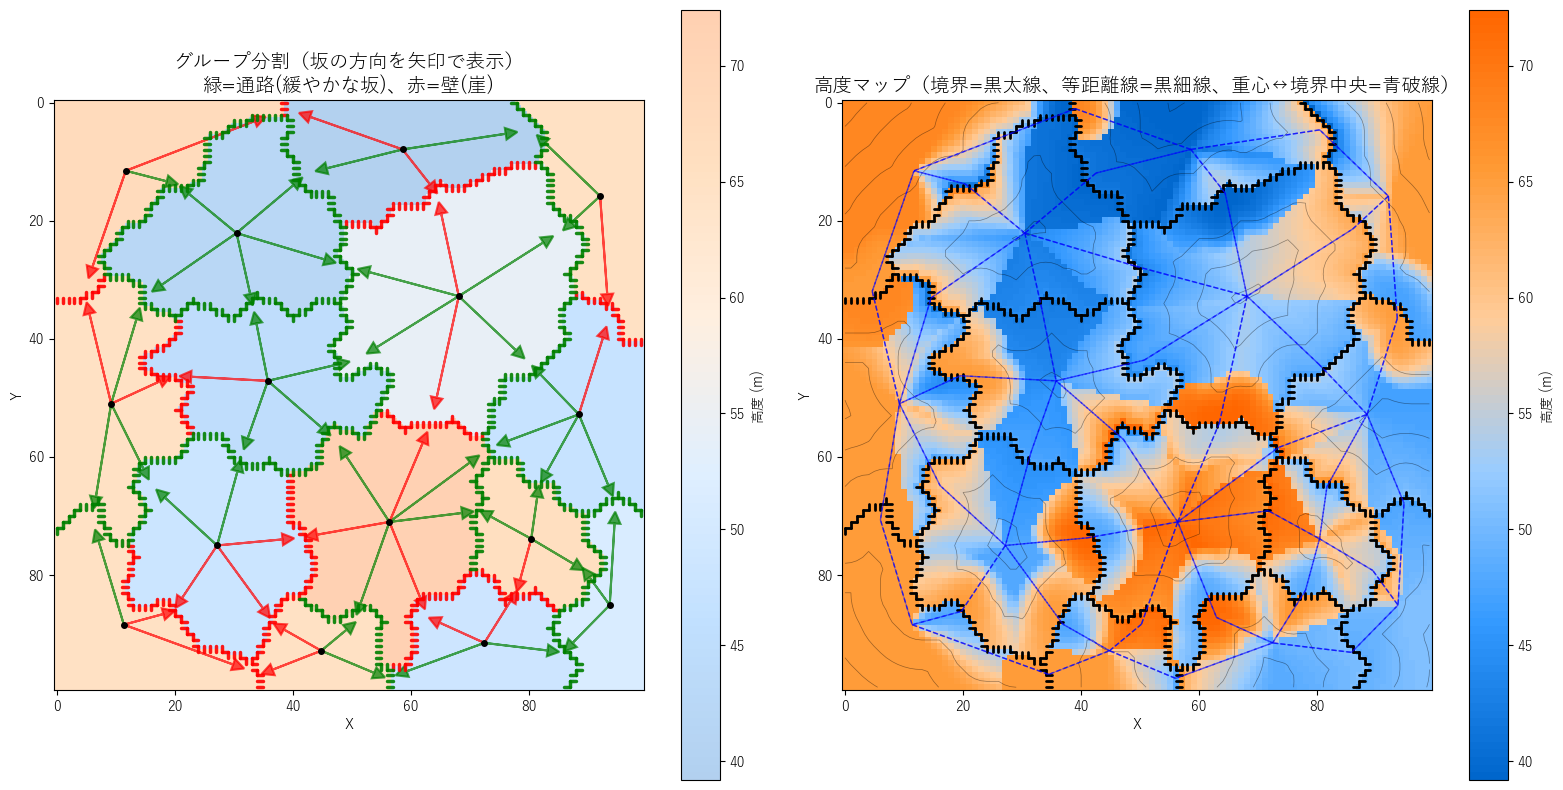

In [9]:
# カスタムカラーマップ:青→オレンジ
colors_blue_orange = ['#0066cc', '#3399ff', '#99ccff', '#ffcc99', '#ff9933', '#ff6600']
n_bins = 100
cmap_blue_orange = LinearSegmentedColormap.from_list('blue_orange', colors_blue_orange, N=n_bins)

# グループ重心を計算
group_centroids = {}
for group_id in range(terrain.num_groups):
    y_coords, x_coords = np.where(terrain.group_map == group_id)
    if len(x_coords) > 0:
        centroid_x = np.mean(x_coords)
        centroid_y = np.mean(y_coords)
        group_centroids[group_id] = (centroid_x, centroid_y)

# グループ構造の可視化（改善版）
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# === 左: グループマップ（高さと境界種別を表示）===
ax1 = axes[0]

# 各グループの高さで色分け（透明度を上げて薄く）
height_based_map = np.zeros((terrain.height, terrain.width))
for y in range(terrain.height):
    for x in range(terrain.width):
        group_id = terrain.group_map[y, x]
        height_based_map[y, x] = terrain.group_heights[group_id]

im1 = ax1.imshow(height_based_map, cmap=cmap_blue_orange, interpolation='nearest', alpha=0.3)

# 境界ピクセルを収集
boundary_segments = {'wall': [], 'passage': []}

for y in range(terrain.height):
    for x in range(terrain.width):
        current_group = terrain.group_map[y, x]
        
        # 右と下の隣接ピクセルをチェック
        for dy, dx in [(0, 1), (1, 0)]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < terrain.height and 0 <= nx < terrain.width:
                neighbor_group = terrain.group_map[ny, nx]
                if neighbor_group != current_group:
                    key = tuple(sorted([current_group, neighbor_group]))
                    is_wall = terrain.is_wall.get(key, False)
                    segment_type = 'wall' if is_wall else 'passage'
                    boundary_segments[segment_type].append(([x, nx], [y, ny]))

# 境界を太い実線で描画
for segment_type, color in [('wall', 'red'), ('passage', 'green')]:
    for xs, ys in boundary_segments[segment_type]:
        ax1.plot(xs, ys, color=color, linewidth=2.5, alpha=0.9, solid_capstyle='round')

# 重心に点を描画
for group_id, centroid in group_centroids.items():
    ax1.plot(centroid[0], centroid[1], 'ko', markersize=4)

# 通路方向への矢印（緑）と壁方向への矢印（赤）
for key, is_wall in terrain.is_wall.items():
    g1, g2 = key
    if g1 in group_centroids and g2 in group_centroids:
        if key not in terrain.boundary_centroids:
            continue
        
        c1 = group_centroids[g1]
        c2 = group_centroids[g2]
        boundary_center = terrain.boundary_centroids[key]
        
        color = 'red' if is_wall else 'green'
        arrow_alpha = 0.7
        
        # g1から境界中央への矢印
        dx1 = boundary_center[0] - c1[0]
        dy1 = boundary_center[1] - c1[1]
        ax1.arrow(c1[0], c1[1], dx1*0.8, dy1*0.8, 
                 head_width=2, head_length=2, fc=color, ec=color, alpha=arrow_alpha, linewidth=1.5)
        
        # g2から境界中央への矢印
        dx2 = boundary_center[0] - c2[0]
        dy2 = boundary_center[1] - c2[1]
        ax1.arrow(c2[0], c2[1], dx2*0.8, dy2*0.8, 
                 head_width=2, head_length=2, fc=color, ec=color, alpha=arrow_alpha, linewidth=1.5)

ax1.set_title('グループ分割（坂の方向を矢印で表示）\n緑=通路(緩やかな坂)、赤=壁(崖)', fontsize=14)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
plt.colorbar(im1, ax=ax1, label='高度 (m)')

# === 右: 高度マップ（境界と等距離線を描画）===
ax2 = axes[1]
im2 = ax2.imshow(terrain.height_map, cmap=cmap_blue_orange, interpolation='nearest')

# 境界を太い黒実線で描画
for xs, ys in boundary_segments['wall'] + boundary_segments['passage']:
    ax2.plot(xs, ys, color='black', linewidth=2.0, alpha=1.0, solid_capstyle='round')

# 等距離線を細線で描画（マトリョーシカ形状）
for group_id in range(terrain.num_groups):
    # グループ全境界への距離マップ（マトリョーシカ用）
    dist_to_boundary = terrain.distance_to_boundary.get(group_id, {})
    
    if len(dist_to_boundary) == 0:
        continue
    
    # 距離マップを2D配列に変換
    dist_map = np.full((terrain.height, terrain.width), np.nan)
    for (px, py), dist in dist_to_boundary.items():
        dist_map[py, px] = dist
    
    # matplotlibのcontourを使用して等距離線を描画
    x_grid = np.arange(terrain.width)
    y_grid = np.arange(terrain.height)
    
    # 等距離線を描画（5, 10, 15, 20, 25ピクセル）
    for target_dist in [5, 10, 15, 20, 25]:
        valid_mask = ~np.isnan(dist_map)
        
        if valid_mask.sum() > 10:
            try:
                contour_set = ax2.contour(x_grid, y_grid, dist_map, 
                                         levels=[target_dist], 
                                         colors='black', 
                                         linewidths=0.5, 
                                         alpha=0.4)
            except:
                pass

# 重心と境界中央を結ぶ線を描画（折れ線）
for group_id in range(terrain.num_groups):
    if group_id not in group_centroids:
        continue
    
    centroid = group_centroids[group_id]
    
    # この群の各境界について
    for neighbor_id in terrain.group_boundaries[group_id].keys():
        key = tuple(sorted([group_id, neighbor_id]))
        if key not in terrain.boundary_centroids:
            continue
        
        boundary_center = terrain.boundary_centroids[key]
        
        # 重心から境界中央への線（青い破線）
        ax2.plot([centroid[0], boundary_center[0]], [centroid[1], boundary_center[1]], 
                'b--', linewidth=1, alpha=0.6)
        
        # 境界中央から隣接グループ重心への線（青い破線）
        if neighbor_id in group_centroids:
            neighbor_centroid = group_centroids[neighbor_id]
            ax2.plot([boundary_center[0], neighbor_centroid[0]], 
                    [boundary_center[1], neighbor_centroid[1]], 
                    'b--', linewidth=1, alpha=0.6)

ax2.set_title('高度マップ（境界=黒太線、等距離線=黒細線、重心↔境界中央=青破線）', fontsize=14)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
plt.colorbar(im2, ax=ax2, label='高度 (m)')

plt.tight_layout()
plt.show()

## 4. 表面メッシュ3D可視化

In [10]:
def create_surface_mesh_3d(terrain, resolution=2):
    """表面メッシュのみの3D地形"""
    height, width = terrain.height_map.shape
    
    x = np.arange(0, width, resolution)
    y = np.arange(0, height, resolution)
    X, Y = np.meshgrid(x, y)
    
    Z = terrain.height_map[::resolution, ::resolution]
    
    return X, Y, Z

# カスタムカラースケール：青→オレンジ
blue_orange_scale = [
    [0.0, 'rgb(0, 102, 204)'],      # 深い青
    [0.2, 'rgb(51, 153, 255)'],     # 青
    [0.4, 'rgb(153, 204, 255)'],    # 明るい青
    [0.6, 'rgb(255, 204, 153)'],    # 明るいオレンジ
    [0.8, 'rgb(255, 153, 51)'],     # オレンジ
    [1.0, 'rgb(255, 102, 0)']       # 濃いオレンジ
]

# 表面メッシュを生成
X, Y, Z = create_surface_mesh_3d(terrain, resolution=1)

# Plotlyで表面メッシュ
fig = go.Figure(data=[go.Surface(
    x=X,
    y=Y,
    z=Z,
    colorscale=blue_orange_scale,
    colorbar=dict(title="Height (m)"),
    hovertemplate='X: %{x}<br>Y: %{y}<br>Height: %{z:.1f}m<extra></extra>'
)])

fig.update_layout(
    title='Surface Mesh Terrain (Interactive 3D)',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Height (m)',
        aspectmode='manual',
        aspectratio=dict(x=2, y=2, z=1),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.2)
        )
    ),
    width=1000,
    height=800
)

fig.show()

## 5. 統計情報と検証

In [6]:
# グループサイズの詳細統計
print("=== グループサイズ統計 ===")
sizes = sorted(group_sizes.values(), reverse=True)
print(f"最大3グループ: {sizes[:3]}")
print(f"最小3グループ: {sizes[-3:]}")
print(f"サイズ比（最大/最小）: {sizes[0] / sizes[-1]:.2f}")
print(f"\n目標比率: 9:3:1 = {9}:{3}:{1}")
print(f"実際の比率: {sizes[0]}:{sizes[len(sizes)//2]}:{sizes[-1]}")

# 高度統計
print("\n=== 高度統計 ===")
print(f"最低高度: {terrain.height_map.min():.1f}m")
print(f"最高高度: {terrain.height_map.max():.1f}m")
print(f"平均高度: {terrain.height_map.mean():.1f}m")
print(f"高度差: {terrain.height_map.max() - terrain.height_map.min():.1f}m")

# 壁と通路の統計
num_walls = sum(1 for is_wall in terrain.is_wall.values() if is_wall)
num_passages = len(terrain.is_wall) - num_walls
print("\n=== 構造統計 ===")
print(f"壁の数: {num_walls}")
print(f"通路の数: {num_passages}")
print(f"通路比率: {num_passages / len(terrain.is_wall) * 100:.1f}%")

# 通路の高度差統計
passage_height_diffs = []
for key, is_wall in terrain.is_wall.items():
    if not is_wall:  # 通路
        g1, g2 = key
        diff = abs(terrain.group_heights[g1] - terrain.group_heights[g2])
        passage_height_diffs.append(diff)

if passage_height_diffs:
    print("\n=== 通路の高度差 ===")
    print(f"最小: {min(passage_height_diffs):.1f}m")
    print(f"最大: {max(passage_height_diffs):.1f}m")
    print(f"平均: {np.mean(passage_height_diffs):.1f}m")
    print(f"目標範囲: 2-4m")

=== グループサイズ統計 ===
最大3グループ: [24, 22, 19]
最小3グループ: [10, 7, 4]
サイズ比（最大/最小）: 6.00

目標比率: 9:3:1 = 9:3:1
実際の比率: 24:12:4

=== 高度統計 ===
最低高度: 39.3m
最高高度: 71.7m
平均高度: 56.5m
高度差: 32.5m

=== 構造統計 ===
壁の数: 11
通路の数: 21
通路比率: 65.6%

=== 通路の高度差 ===
最小: 0.4m
最大: 29.0m
平均: 10.7m
目標範囲: 2-4m


## 6. 傾斜角度の検証

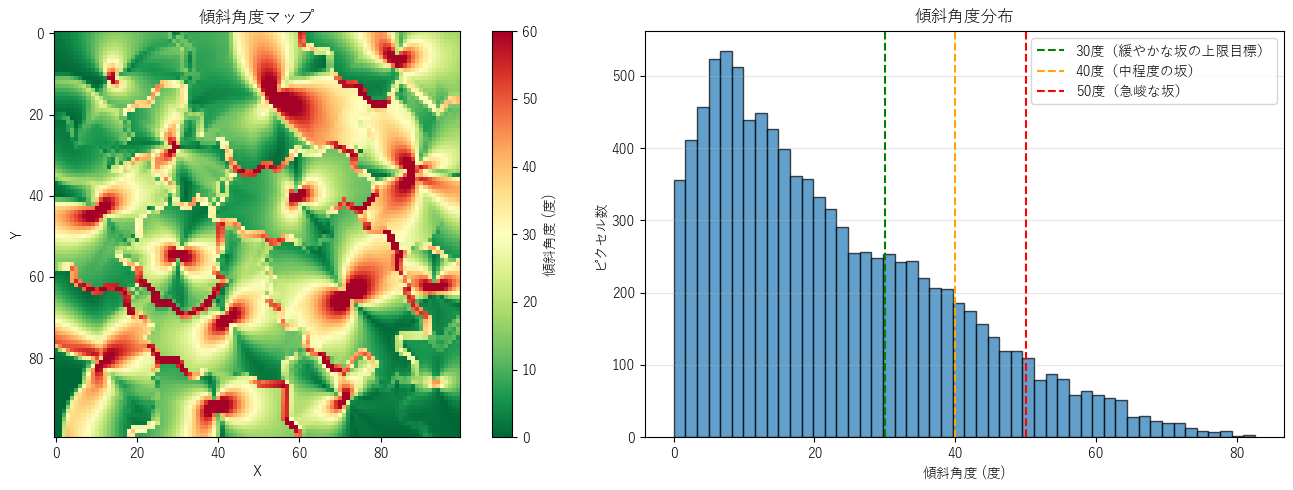


=== 傾斜角度統計 ===
平地（0-10度）: 2819 ピクセル (28.2%)
緩やか（10-40度）: 5530 ピクセル (55.3%)
急峻（40度以上）: 1651 ピクセル (16.5%)
最大傾斜角度: 82.6度
平均傾斜角度: 22.6度

30-40度の緩やかな坂: 1374 ピクセル (13.7%)
✅ 改善目標: 広範囲補間により30-40度の坂が増加


In [7]:
# 傾斜角度を計算
def calculate_slope_angles(height_map):
    """各ピクセルの傾斜角度を計算"""
    dy, dx = np.gradient(height_map)
    slope = np.sqrt(dx**2 + dy**2)
    angle = np.arctan(slope) * 180 / np.pi  # 度に変換
    return angle

angles = calculate_slope_angles(terrain.height_map)

# 傾斜角度の分布
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.imshow(angles, cmap='RdYlGn_r', vmin=0, vmax=60)
plt.colorbar(label='傾斜角度 (度)')
plt.title('傾斜角度マップ')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 2, 2)
plt.hist(angles.flatten(), bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=30, color='g', linestyle='--', label='30度（緩やかな坂の上限目標）')
plt.axvline(x=40, color='orange', linestyle='--', label='40度（中程度の坂）')
plt.axvline(x=50, color='r', linestyle='--', label='50度（急峻な坂）')
plt.xlabel('傾斜角度 (度)')
plt.ylabel('ピクセル数')
plt.title('傾斜角度分布')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 統計
flat = np.sum(angles < 10)
gentle = np.sum((angles >= 10) & (angles < 40))
steep = np.sum(angles >= 40)
total = angles.size

print(f"\n=== 傾斜角度統計 ===")
print(f"平地（0-10度）: {flat} ピクセル ({flat/total*100:.1f}%)")
print(f"緩やか（10-40度）: {gentle} ピクセル ({gentle/total*100:.1f}%)")
print(f"急峻（40度以上）: {steep} ピクセル ({steep/total*100:.1f}%)")
print(f"最大傾斜角度: {angles.max():.1f}度")
print(f"平均傾斜角度: {angles.mean():.1f}度")

# 30-40度の坂の割合
moderate = np.sum((angles >= 30) & (angles < 40))
print(f"\n30-40度の緩やかな坂: {moderate} ピクセル ({moderate/total*100:.1f}%)")
print(f"✅ 改善目標: 広範囲補間により30-40度の坂が増加")